## Neural Machine Translation using Google's Encoder Decoder Architecture

### Importing all the dependencies

In [1]:
import tensorflow as tf
from keras import Input
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import tarfile
import os
import random
import matplotlib.pyplot as plt

### Getting one with the dataset

In [2]:
# Extracting all the files from the tar file
if not os.path.exists('/Users/klsharma22/Desktop/EncoderDecoderExp/wiki'):
    tar_ref = tarfile.TarFile('/Users/klsharma22/Desktop/EncoderDecoderExp/wiki-titles.tar')
    tar_ref.extractall()
    print('Files extracted')

In [3]:
# Extracting data from the file
with open('/Users/klsharma22/Desktop/EncoderDecoderExp/wiki/hi-en/wiki-titles.hi-en', 'r') as f:
    lines = f.readlines()

len(lines)

32863

In [4]:
# Separating english from hindi
hin_sentences = [line.split('|||')[0] for line in lines]
eng_sentences = [line.split('|||')[1][:-1] for line in lines]
len(hin_sentences), len(eng_sentences)

(32863, 32863)

### Visualising the dataset we have

In [5]:
random_idx = random.choices(range(len(hin_sentences)), k= 5)
for idx in random_idx:
    print(f"English sentence: {eng_sentences[idx]}")
    print(f"Hindi sentce: {hin_sentences[idx]}")
    print('--------------------\n')

English sentence:  Cancer
Hindi sentce: कर्कट रोग 
--------------------

English sentence:  Northern Sami Wikipedia
Hindi sentce: उत्तरी सामी विकिपीडिया 
--------------------

English sentence:  Flag of Saudi Arabia
Hindi sentce: सऊदी अरब का ध्वज 
--------------------

English sentence:  Muhammad Iqbal
Hindi sentce: मुहम्मद इक़बाल 
--------------------

English sentence:  Beas River
Hindi sentce: ब्यास नदी 
--------------------


In [6]:
# Lets look at the distibution of number of words per sentence
eng_words_sentences = [len(sentence.split()) for sentence in eng_sentences]
hin_word_sentences = [len(sentence.split()) for sentence in hin_sentences]

len(eng_words_sentences), len(hin_word_sentences)

(32863, 32863)

In [7]:
# Create vocabulary set for both the language
eng_vocab = set()

for line in eng_sentences:
    for word in line.split():
        eng_vocab.add(word)

eng_vocab.add('<SOS>')
eng_vocab.add('<EOS>')
len(eng_vocab)

28853

In [8]:
english_dictionary = pd.DataFrame(eng_vocab)

In [9]:
# Cross verifying the values
english_dictionary.nunique()

0    28853
dtype: int64

In [10]:
# Storing vocab value of hindi same as english
hin_vocab = set()

for line in hin_sentences:
    for word in line.split():
        hin_vocab.add(word)

len(hin_vocab)

29073

In [11]:
# Cross verifying
hindi_dictionary = pd.DataFrame(hin_vocab)
hindi_dictionary.nunique()

0    29073
dtype: int64

(array([2.4237e+04, 5.2690e+03, 2.4600e+03, 3.4200e+02, 2.4100e+02,
        2.9000e+02, 1.1000e+01, 1.1000e+01, 1.0000e+00, 1.0000e+00]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <BarContainer object of 10 artists>)

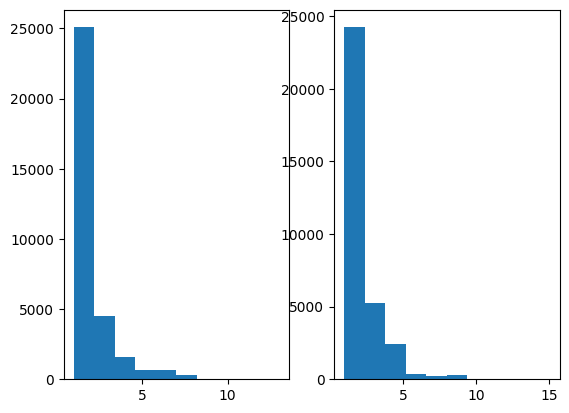

In [12]:
# Plotting number of words distribution
plt.subplot(1, 2, 1)
plt.hist(eng_words_sentences)

plt.subplot(1, 2, 2)
plt.hist(hin_word_sentences)

In [13]:
# Let's cover the maximum number of data
max_len_eng = np.percentile(eng_words_sentences, 0.99)
max_len_hin = np.percentile(hin_word_sentences, 0.99)
max_len_eng, max_len_hin

(1.0, 1.0)

## Preprocess the data

In [14]:
def preprocess_sentence(sentences: list):
    return ['<SOS> ' + sentence.strip() + ' <EOS>' for sentence in sentences]

In [15]:
eng_sentences_preprocessed = preprocess_sentence(eng_sentences)
hin_sentences_preprocessed = preprocess_sentence(hin_sentences)

In [16]:
random_idx = random.randint(0, len(eng_sentences_preprocessed) - 1)
print(eng_sentences_preprocessed[random_idx])
print(hin_sentences_preprocessed[random_idx])

<SOS> Gibraltar Social Democrats <EOS>
<SOS> जिब्राल्टर सोशल डैमोक्रैट्स <EOS>


### Create Encoder class

In [37]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self, vocab, embedding_size, units, encoding_layers, **kwargs):
        # initialisation of the variables
        super().__init__(**kwargs)
        self.vocab = vocab
        self.units = units
        self.encoding_layers = encoding_layers
        self.embedding_size = embedding_size
        # self.output = None

        #initialisation of the layers required
        # self.input_layer = layers.Input(shape= (None, ), dtype= tf.int32)
        self.embedding = layers.Embedding(input_dim= self.vocab,
                                          output_dim= self.embedding_size,name= 'encoder_embedding_layer')
        self.lstm_init_units = 2 * (self.embedding_size + self.units)
        self.lstm_layers_recurrent = []
        self.lstm_layers_recurrent.append(layers.LSTM(self.lstm_init_units, return_sequences=True, name= 'lst_layers_recurrent_0'))
        self.lstm_units = self.lstm_init_units
        for _ in range(self.encoding_layers - 3):
            self.lstm_units += (self.embedding_size + self.units)
            self.lstm_layers_recurrent.append(layers.LSTM(self.lstm_units, return_sequences=True, name=f'lstm_layers_recurrent_{_ + 1}'))
        self.lstm_layer_non_recurrent = layers.LSTM(self.units, return_sequences=False, return_state= True, name= 'lstm_layer_non_recurrent')
        self.bilst_layer = layers.Bidirectional(layers.LSTM(self.units // 2, return_sequences=True), name= 'bilst_layer')
        self.concatenate_layer = layers.Concatenate(name= 'concatenate_layer')
        self.dropout_layer = layers.Dropout(0.5, name= 'dropout_layer')
        

    def call(self, inputs):
        x = self.embedding(inputs)
        bilstm_output = self.bilst_layer(x)
        x = self.dropout_layer(bilstm_output)
        x = self.concatenate_layer([bilstm_output, x])
        for i in range(self.encoding_layers - 2):
            lstm_layer_output = self.lstm_layers_recurrent[i](x)
            lstm_layer_output = self.dropout_layer(lstm_layer_output)
            x = self.concatenate_layer([lstm_layer_output, x])
        x, [h, c] = self.lstm_layer_non_recurrent(x)
        output = self.dropout_layer(x)
        # x = tf.keras.layers.Dense(15, activation= 'softmax')(x)
        
        return output, [h, c]
    


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(eng_sentences_preprocessed, hin_sentences_preprocessed, test_size= 0.2,
                                                    random_state= 42)
len(X_train), len(X_test), len(y_train), len(y_test)

(26290, 6573, 26290, 6573)

In [39]:
# Creating a text vectorization for the source language
eng_vectorizer = layers.TextVectorization(max_tokens= len(eng_vocab),
                                          pad_to_max_tokens= True,
                                          name= 'eng_vectorizer')

eng_vectorizer.adapt(X_train)



In [40]:
# A sample action of our text vectorization
random_text = random.choice(X_train)
print(f"Original text: {random_text}")
print(f"Vectorized text: {eng_vectorizer(random_text)}")

Original text: <SOS> Positron emission tomography <EOS>
Vectorized text: [   2 4017 1159 3393    3]


In [41]:
# Creating an instance of our encoder layer
encoder_layer = Encoder(vocab= len(eng_vocab),
                        embedding_size= 128,
                        units= 512,
                        encoding_layers= 8,
                        name= 'encoder_layer', trainable= True)


encoder_layer.get_config()

{'name': 'encoder_layer',
 'vocab': 28853,
 'embedding_size': 128,
 'units': 512,
 'encoding_layers': 8,
 'trainable': True,
 'dtype': 'float32'}

In [42]:
print(len(X_train[0].split()))
print(eng_vectorizer(X_train[0]).shape)

4
(4,)


In [47]:
with tf.device('GPU:0'):
    output, final_memory_state, final_carry_state = encoder_layer(eng_vectorizer(X_train[:128]))
    
print(output.shape, final_memory_state.shape, final_carry_state.shape)

(128, 512) (128, 512) (128, 512)


In [24]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, eng_vectorizer(X_train))).batch(128).prefetch(tf.data.AUTOTUNE)
valid_data = tf.data.Dataset.from_tensor_slices((X_test, eng_vectorizer(X_test))).batch(128).prefetch(tf.data.AUTOTUNE)

In [25]:
model = tf.keras.Sequential([
    eng_vectorizer,
    encoder_layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.build()
model.summary(expand_nested= True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ eng_vectorizer                  │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer (Encoder)         │ ?                      │   824,932,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 824,932,480 (3.07 GB)

 Trainable params: 824,932,480 (3.07 GB)

 Non-trainable params: 0 (0.00 B)

In [26]:
hin_vectorizer = tf.keras.layers.TextVectorization(max_tokens= len(hin_vocab),
                                                   pad_to_max_tokens= True,
                                                   name= 'hin_vectorizer')

hin_vectorizer.adapt(y_train)

In [27]:
random_text = random.choice(y_train)

print(f"Hindi text: {random_text}")
print(f"Vectorize text: {hin_vectorizer(random_text)}")

Hindi text: <SOS> १७९२ <EOS>
Vectorize text: [   2 6611    3]


In [56]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, units, vocab_size, embedding_size, decoding_layers, initial_state_size, **kwargs):
        super().__init__(**kwargs)
        
        # self.initial_state = initial_state
        self.units = units
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.decoding_layers = decoding_layers
        self.initial_state_size = initial_state_size
        
        # initializing all the layers
        self.initial_state = tf.keras.layers.Input(shape= (self.initial_state_size,), name= 'decoder_initial_state')
        self.embedding = tf.keras.layers.Embedding(input_dim= self.vocab_size,
                                                   output_dim= self.embedding_size,
                                                   name= 'decoder_embedding_layer')
        # self.decoder_input = tf.keras.layers.Input(shape= (None, ), name= 'decoder_input', dtype= 'string')
        self.concatenate_layer = tf.keras.layers.Concatenate(name= 'concatenate_layer')
        self.lstm_layers_recurrent = []
        for i in range(self.decoding_layers):
            self.lstm_layers_recurrent.append(tf.keras.layers.LSTM(self.units, return_sequences=True, name= f'decoder_lstm_layer_{i}'))
            
        self.dense = tf.keras.layers.Dense(vocab_size, activation= 'softmax', name='decode_output_layer')
        
        
    def call(self, inputs, initial_state= None):
        if initial_state == None:
            initial_state = self.initial_state
        x = self.embedding(inputs)
        x = self.lstm_layers_recurrent[0](x, initial_state=initial_state)
        x = self.lstm_layers_recurrent[1](x, initial_state=initial_state)
        for i in range(2, self.decoding_layers - 1):
            lstm_output = self.lstm_layers_recurrent[i](x, initial_state)
            x = self.concatenate_layer([x, lstm_output])
        
        x = self.lstm_layers_recurrent[-1](x)
        x = self.dense(x)
        
        return x

In [57]:
decoder_layer = Decoder(units= 512,
                        vocab_size= len(hin_vocab),
                        embedding_size= 128,
                        decoding_layers= 8,
                        initial_state_size= 512,
                        name= 'decoding_layer',
                        trainable= True)
decoder_layer.get_config()

{'name': 'decoding_layer',
 'units': 512,
 'vocab_size': 29073,
 'embedding_size': 128,
 'decoding_layers': 8,
 'initial_state_size': 512,
 'trainable': True,
 'dtype': 'float32'}

In [59]:
with tf.device('/gpu:0'):
    encoder_output, final_memory_state, final_carry_state = encoder_layer(eng_vectorizer(X_train[:128]))
    decoder_output = decoder_layer(hin_vectorizer(y_train[:128]), initial_state= [final_memory_state, final_carry_state])
    
decoder_output.shape

TensorShape([128, 9, 29073])

## Model Creation

We have created encoder and decoder as layer in the above code using subclass method and also we have created text vecotrizer usign keras `TextVectorization` layer.

Let's list the component in the order we want to build the mode:
1. Encoder Text Vectorization
2. Encoder layer with in built embedding layer
3. Decoder Text Vectorizartion
4. Decoder layer connected with in built embedding layer and feature for initial state for encoder output

In [67]:
# Creating the entire encoder decoder model
inputs_encoder = tf.keras.layers.Input(shape=(None, ), dtype= 'string', name= 'encoder_input_layer')
encoder_text_vectors = eng_vectorizer(inputs_encoder)
encoder_outputs, final_memory_states, final_carry_states = encoder_layer(encoder_text_vectors)

inputs_decoder =  tf.keras.layers.Input(shape= (None, ), dtype= 'string', name= 'decoder_input_layer')
decoder_text_vectors = hin_vectorizer(inputs_decoder)
decoder_outputs = decoder_layer(decoder_text_vectors, initial_state= [final_memory_states, final_carry_states])

model = tf.keras.Model(inputs = [inputs_encoder, inputs_decoder], outputs =[decoder_outputs])

model.compile(loss= 'sparse_categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(learning_rate= 1e-3))

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_layer │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input_layer │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eng_vectorizer      │ (None, None)      │          0 │ encoder_input_la… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hin_vectorizer      │ (None, None)      │          0 │ decoder_input_la… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer       │ [(None, 512),     │ 824,932,4… │ eng_vectorizer[2… │
│ (Encoder)           │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoding_layer      │ (None, None,      │ 50,371,601 │ hin_vectorizer[0… │
│ (Decoder)           │ 29073)            │            │ encoder_layer[2]… │
│                     │                   │            │ encoder_layer[2]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 875,304,081 (3.26 GB)

 Trainable params: 875,304,081 (3.26 GB)

 Non-trainable params: 0 (0.00 B)

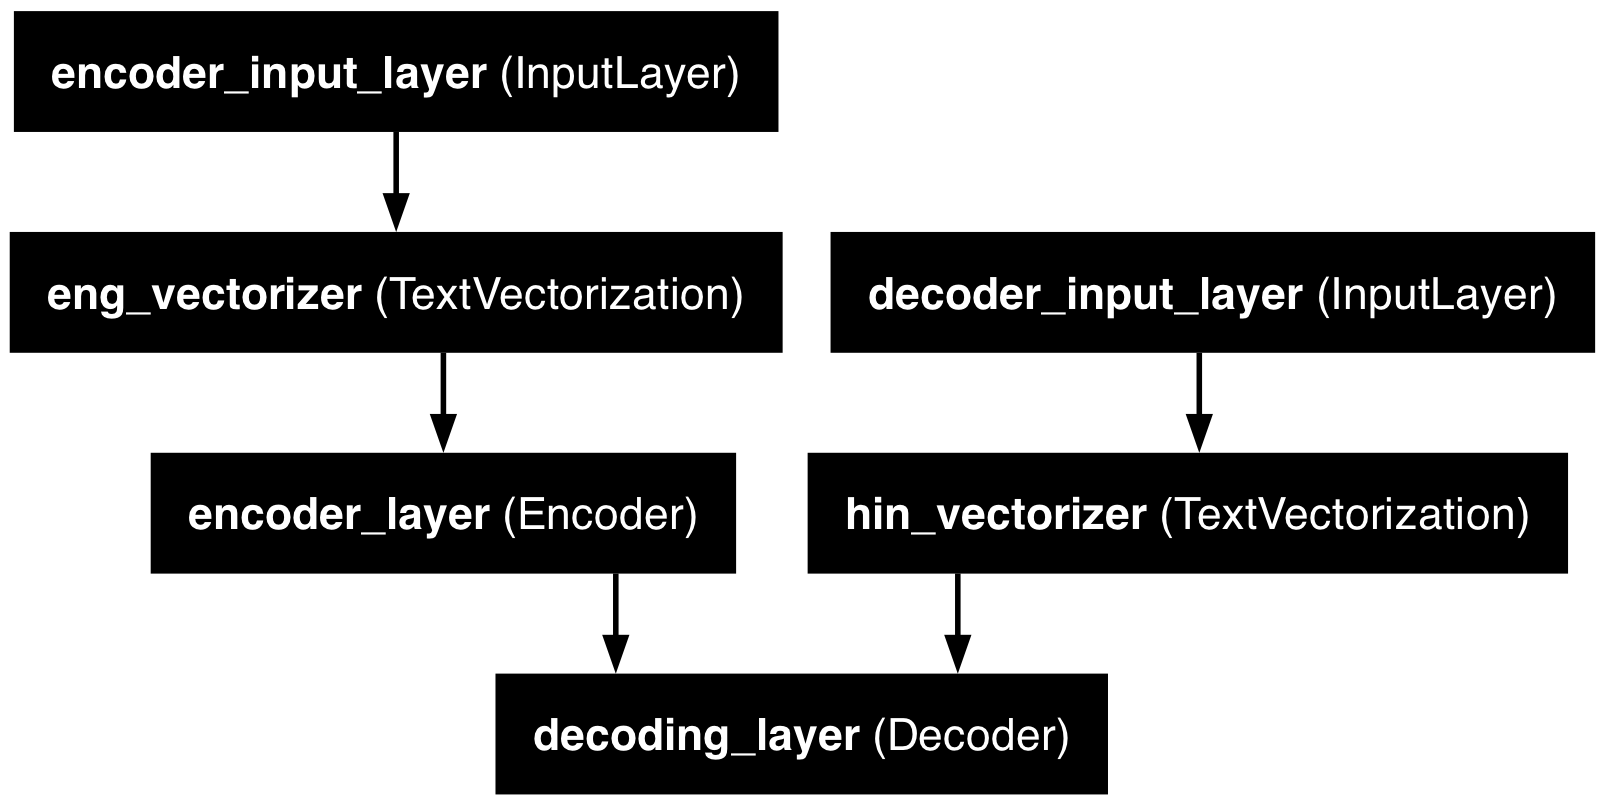

In [71]:
tf.keras.utils.plot_model(model, show_layer_names= True)

## Creating dataset for faster and better training of the model

Using `tf.data` API, we are going to create a better pipeline to train the model usign batch and prefetch method